In [1]:
#Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras.layers import Dense,Flatten,GlobalAveragePooling2D
from keras import layers as ml

from keras.preprocessing.image import ImageDataGenerator as Imgen

from PIL import Image

from sklearn.metrics import classification_report,confusion_matrix

import os
import glob

from keras.preprocessing import image

### **Loading the Data**

In [2]:
path = "../input/face-mask-12k-images-dataset/Face Mask Dataset/"

In [3]:
dataset = {"image_path":[],"mask_status":[],"where":[]}
for where in os.listdir(path):
    for status in os.listdir(path+"/"+where):
        for image in glob.glob(path+where+"/"+status+"/"+"*.png"):
            dataset["image_path"].append(image)
            dataset["mask_status"].append(status)
            dataset["where"].append(where)
dataset = pd.DataFrame(dataset)
dataset

,image_path,mask_status,where
0,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation
1,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation
2,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation
3,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation
4,../input/face-mask-12k-images-dataset/Face Mas...,WithoutMask,Validation
...,...,...,...
11787,../input/face-mask-12k-images-dataset/Face Mas...,WithMask,Train
11788,../input/face-mask-12k-images-dataset/Face Mas...,WithMask,Train
11789,../input/face-mask-12k-images-dataset/Face Mas...,WithMask,Train
11790,../input/face-mask-12k-images-dataset/Face Mas...,WithMask,Train


In [4]:
dataset.mask_status.value_counts()

WithoutMask    5909
WithMask       5883
Name: mask_status, dtype: int64

In [5]:
train_df = dataset[dataset['where'] == "Train"]
val_df = dataset[dataset["where"] == "Validation"]
test_df = dataset[dataset["where"] == "Test"]

In [6]:
test_df.image_path[:2]

800    ../input/face-mask-12k-images-dataset/Face Mas...
801    ../input/face-mask-12k-images-dataset/Face Mas...
Name: image_path, dtype: object

In [7]:
train_ds = Imgen(rescale=1./255).flow_from_dataframe(dataframe=train_df,
                                                     directory="../input",
                                                     x_col='image_path',
                                                     y_col='mask_status',
                                                    target_size=(150,150),
                                                    seed = 123,
                                                    batch_size= 60,
                                                     shuffle = False,
                                                     class_mode ="binary"
                                                    )

Found 10000 validated image filenames belonging to 2 classes.


In [8]:
val_ds = Imgen(rescale=1./255).flow_from_dataframe(dataframe=val_df,
                                                     directory="../input",
                                                     x_col='image_path',
                                                     y_col='mask_status',
                                                    target_size=(150,150),
                                                    seed = 123,
                                                    batch_size= 60,
                                                     shuffle = False,
                                                     class_mode ="binary"
                                                    )

Found 800 validated image filenames belonging to 2 classes.


In [9]:
test_ds = Imgen(rescale=1./255).flow_from_dataframe(dataframe=test_df,
                                                     directory="../input",
                                                     x_col='image_path',
                                                     y_col='mask_status',
                                                    target_size=(150,150),
                                                    seed = 123,
                                                    batch_size= 60,
                                                     shuffle = False,
                                                     class_mode ="binary"
                                                    )

Found 992 validated image filenames belonging to 2 classes.


**Visualizing**

In [10]:
train_ds.class_indices

{'WithMask': 0, 'WithoutMask': 1}

In [11]:
pred_class = list(train_ds.class_indices.keys())
pred_class

['WithMask', 'WithoutMask']

In [12]:
dist = train_ds.classes
len(dist)

10000

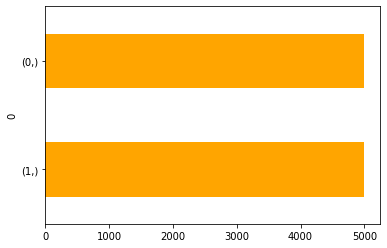

In [13]:
un_dist = pd.DataFrame(dist).value_counts()
un_dist.plot(kind='barh',color='orange');

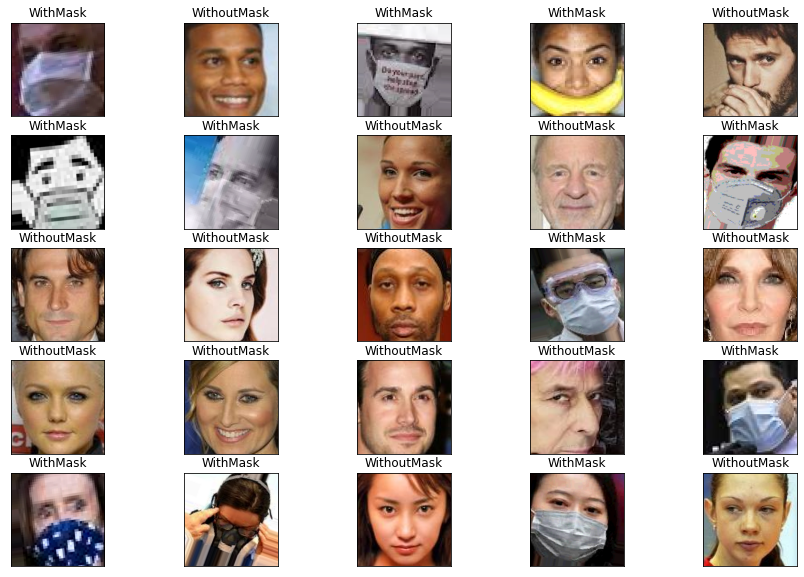

In [14]:
plt.figure(figsize=(15,10))
for i in range(25):
    n = np.random.randint(1,9000)
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Image.open(train_df.image_path.iloc[n]))
    plt.title(train_df.mask_status.iloc[n])


## **Model**

In [15]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

In [16]:
base_model = InceptionResNetV2(include_top=False,
                              weights='imagenet',
                              input_shape=(150,150,3))
base_model.trainable = False

219062272/219055592 [==============================] - 2s 0us/step


In [17]:
model = keras.models.Sequential()

model.add(base_model)

model.add(Flatten())

model.add(Dense(64,activation='relu'))

model.add(Dense(1,activation='sigmoid'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 13824)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                884800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 55,221,601
Trainable params: 884,865
Non-trainable params: 54,336,736
_________________________________________________________________


In [19]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [20]:
#callbacks
my_calls = [keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3),
            keras.callbacks.ModelCheckpoint("Model.h5",verbose=1,save_best_only=True)]

**Train**

In [22]:
hist = model.fit(train_ds,epochs=10,validation_data=val_ds,callbacks=my_calls)

Epoch 1/10
167/167 [==============================] - 83s 403ms/step - loss: 2.4651 - accuracy: 0.8599 - val_loss: 0.0126 - val_accuracy: 0.9962

Epoch 00001: val_loss improved from inf to 0.01263, saving model to Model.h5
Epoch 2/10
167/167 [==============================] - 31s 187ms/step - loss: 0.0186 - accuracy: 0.9941 - val_loss: 0.0099 - val_accuracy: 0.9962

Epoch 00002: val_loss improved from 0.01263 to 0.00985, saving model to Model.h5
Epoch 3/10
167/167 [==============================] - 31s 185ms/step - loss: 0.0138 - accuracy: 0.9953 - val_loss: 0.0064 - val_accuracy: 0.9975

Epoch 00003: val_loss improved from 0.00985 to 0.00635, saving model to Model.h5
Epoch 4/10
167/167 [==============================] - 31s 186ms/step - loss: 0.0070 - accuracy: 0.9984 - val_loss: 0.0059 - val_accuracy: 1.0000

Epoch 00004: val_loss improved from 0.00635 to 0.00589, saving model to Model.h5
Epoch 5/10
167/167 [==============================] - 31s 185ms/step - loss: 0.0082 - accuracy: 

**Test**

In [23]:
#load model
model = keras.models.load_model("Model.h5")

In [24]:
model.evaluate(test_ds)

17/17 [==============================] - 10s 388ms/step - loss: 0.0110 - accuracy: 0.9950


[0.010982679203152657, 0.9949596524238586]

**Visualizations**

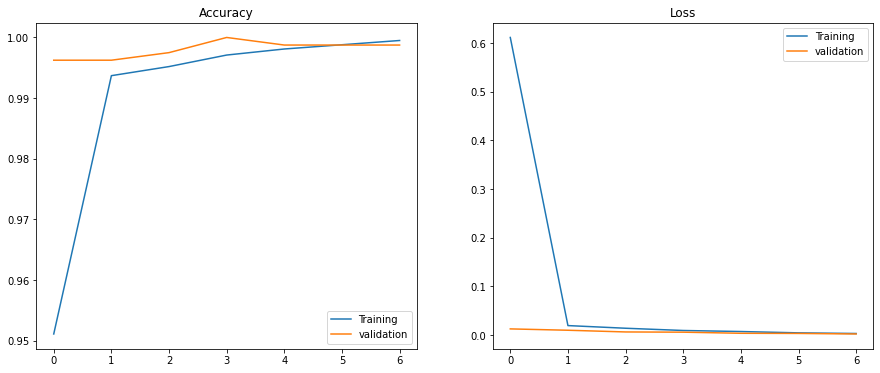

In [25]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(hist.epoch,hist.history['accuracy'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_accuracy'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.epoch,hist.history['loss'],label = 'Training')
plt.plot(hist.epoch,hist.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()

**Test Data**

In [26]:
preds = model.predict(test_ds,verbose=1)

17/17 [==============================] - 7s 179ms/step


In [27]:
 preds = (np.round(preds))

In [28]:
print(classification_report(preds,test_ds.labels))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       484
         1.0       0.99      1.00      1.00       508

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



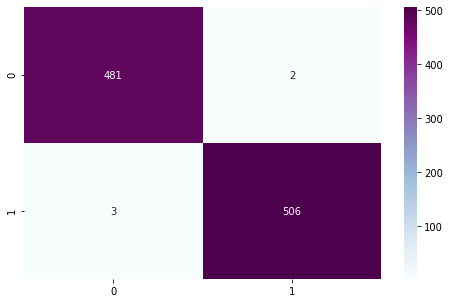

In [29]:
plt.figure(figsize = (8,5))
sns.heatmap(confusion_matrix(test_ds.labels, preds), annot = True,fmt="d",cmap = "BuPu")
plt.show()

**Images**

In [30]:
preds = preds.reshape(-1)
preds  = [int(i) for i in preds]
preds[:5]

[1, 1, 1, 1, 1]

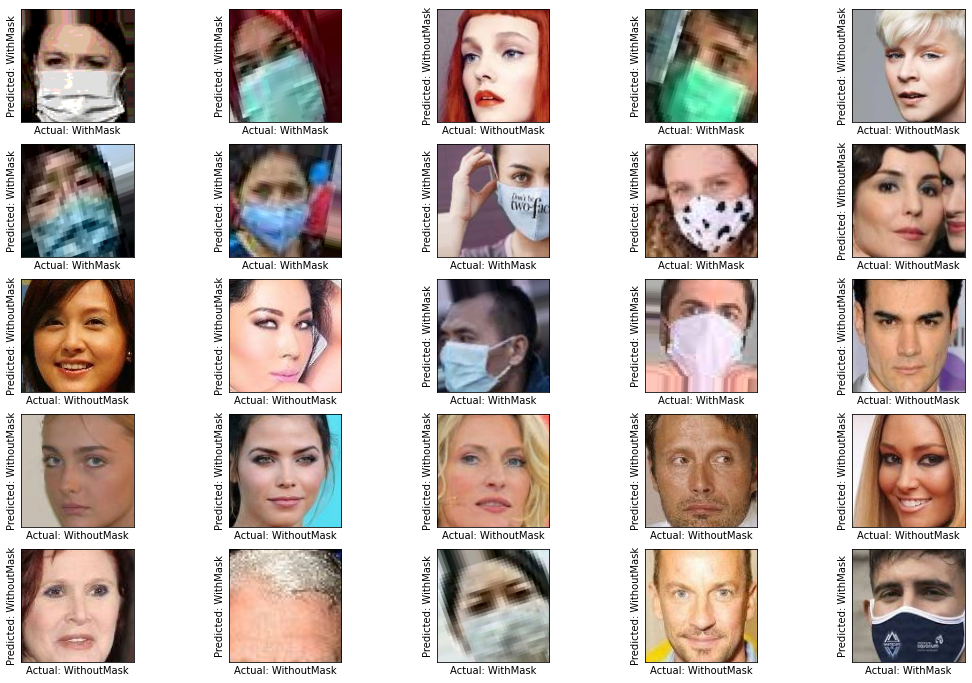

In [31]:
plt.figure(figsize=(18,12))
for i in range(25):
    n = np.random.randint(1,800)
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Image.open(test_df.image_path.iloc[n]))
    plt.xlabel("Actual: {}".format(test_df.mask_status.iloc[n]))
    plt.ylabel("Predicted: {}".format(pred_class[preds[n]]))